In [1]:
import os
import math

import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageDraw

from scorefield.models.ddpm.denoising_diffusion import Unet
from scorefield.models.heat.heat_diffusion import HeatDiffusion
from scorefield.utils.rl_utils import load_config
from scorefield.utils.utils import (
    gen_goals, overlay_goal, overlay_multiple, combine_objects, overlay_images,
    overlay_goal_agent, overlay_goals_agent, log_num_check,
    gen_obstacles, gen_obstacle_masks,
)
from scorefield.utils.diffusion_utils import bilinear_interpolate, bilinear_interpolate_batch

import matplotlib.pyplot as plt
import itertools
import random
from typing import Optional

In [2]:
# Args
config_dir = "./scorefield/configs/heat_diffusion.yaml"
args = load_config(config_dir)
device = args['device']

model_path = os.path.join(args['log_path'], args['model_path'])

# map_img = Image.open("map.png")
bg = Image.open('assets/toy_exp/background0.png')
wastes = []
wastes.append(Image.open('assets/toy_exp/waste0.png'))
wastes.append(Image.open('assets/toy_exp/waste4.png'))
wastes.append(Image.open('assets/toy_exp/waste5.png'))

epochs = args['epochs']
batch_size = args['batch_size']
goal_num = len(wastes)
goal_bounds = args['goal_bounds']
agent_bounds = args['agent_bounds']
eval_samples = args['eval_samples']
obstacle_pos = args['obstacles']

In [3]:
class Unet2D(Unet):
    def __init__(
        self, 
        dim, 
        out_dim, 
        dim_mults=(1, 2, 4, 8)
    ):
        super().__init__(dim=dim, out_dim=out_dim, dim_mults=dim_mults)

    def forward(self, obs, t, x_t:Optional[torch.Tensor]=None):
        score_map = super().forward(obs, t)
        if x_t is not None:
            score = bilinear_interpolate_batch(score_map, x_t)    # output: (B,2)
            return score
        else:
            return score_map.permute(0, 2, 3, 1)

img_size = args['image_size']
noise_steps = args['noise_steps']
train_lr = args['train_lr']
    
model = Unet2D(
    dim=img_size,
    out_dim = 2,
    dim_mults = (1, 2, 4, 8),
).to(device)

diffusion = HeatDiffusion(
    image_size=img_size,
    noise_steps=noise_steps
)

optim = torch.optim.Adam(params=model.parameters(), lr=train_lr)

In [ ]:
# Train with single goal
bg = gen_obstacles(bg, obstacle_pos)
obstacle_masks = gen_obstacle_masks(batch_size, bg.size, img_size, obstacle_pos)

for iters in tqdm(range(epochs)):    
    goal = (torch.rand(batch_size, 2, device=device, dtype=torch.float32) * 0.2 - 0.1) \
                * 0.1 + torch.tensor([[0.7, 0.7]] * batch_size, device=device, dtype=torch.float32)
    goal = goal.unsqueeze(-2)
    obs = overlay_goal(bg, img_size, wastes, goal)
    
    optim.zero_grad()
    
    t = diffusion.sample_timesteps(batch_size).to(device)

    score_field = diffusion.forward_diffusion(goal, t, obstacle_masks)
    score_pred = model(obs, t)
    
    loss = F.mse_loss(score_field, score_pred)
    # loss = F.l1_loss(score_field, score_pred)
    loss.backward()
    optim.step()
    
    if iters % 1000 == 0:
        print(f"iter {iters}: {loss.item()}")


  0%|          | 1/20000 [00:03<19:08:50,  3.45s/it]

iter 0: 0.2330441176891327


  0%|          | 21/20000 [00:53<13:30:22,  2.43s/it]

In [4]:
from tqdm import tqdm
from functools import wraps

bg = gen_obstacles(bg, obstacle_pos)
obstacle_masks = gen_obstacle_masks(noise_steps, bg.size, img_size, obstacle_pos)
goal = torch.tensor([[-0.7,-0.7]] * noise_steps, device=device).unsqueeze(1)
t = torch.tensor([[i+1] for i in range(noise_steps)], device=device)

ut = diffusion.forward_diffusion(goal, t, obstacle_masks)

100%|██████████| 400/400 [1:42:06<00:00, 15.32s/it]


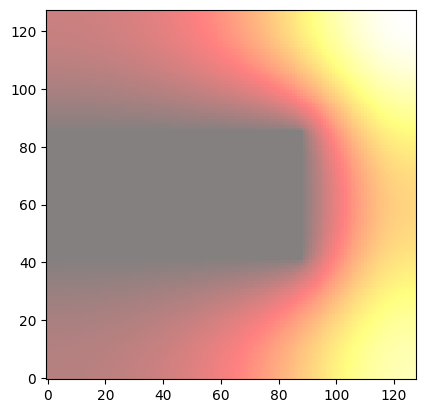

In [5]:
plt.imshow(ut[399].cpu().numpy(), cmap='hot', interpolation='nearest', origin='lower', alpha=0.5)
plt.show()

In [6]:
np.save('./results/heat/heat.npy', ut.cpu().numpy())

In [ ]:
# Train with single + multiple goals

train_goal_num = goal_num * (2**(goal_num - 1)) # if 3 goals: 12
train_goals = [len(list(itertools.combinations([i for i in range(goal_num)], i+1))* (i+1)) \
               for i in range(goal_num)] # if 3 goals: [3, 6, 3]
train_comb = [len(list(itertools.combinations([i for i in range(goal_num)], i+1))) \
              for i in range(goal_num)] # just a list of combinations of goal num. if 3: [3, 3, 1]

assert batch_size % train_goal_num == 0, 'batch size has to be divided by the goal number'
n = batch_size // train_goal_num  # if 3 goals: batch -> n * 12 

for iters in tqdm(range(train_goal_num * epochs)):
    gs = random.randrange(goal_num)        
    goals = gen_goals(goal_bounds, train_goal_num)
    
    expanded_goals = goals.unsqueeze(1).expand(-1, n, -1)
    optim.zero_grad()
    
    random_offsets = (torch.rand(*expanded_goals.shape, device=goals.device, dtype=goals.dtype) * 2 - 1.) * 0.1
    goal_pos = (expanded_goals + random_offsets).view(-1,2)
    obs = []
    st = 0
    for i, t in enumerate(train_goals):
        if i == 0: 
            obs.append(overlay_image(bg, img_size, wastes, goal_pos[st:st + n * t]))
        else:
            obs.append(overlay_images(bg, img_size, wastes, goal_pos[st:st + n * t], i+1))
        st = st + n * t
    x0 = goal_pos.unsqueeze(1)
    obs = torch.cat(obs, dim=0)
    
    # duplicate obs to match the size with x0
    duplicates = []
    for i, tr in enumerate(train_comb):
        if i > 0: 
            duplicates.append(obs[n*prev_tr:n*(prev_tr + tr)].repeat(i,1,1,1))
            tr = prev_tr + tr
        prev_tr = tr

    # TODO: Below new_obs is only capable when the goal number is 3.
    comb_sum = [0] + [n*(train_comb[c]+train_comb[c+1]) for c in range(len(train_comb)-1)]
    new_obs = torch.cat([obs[comb_sum[n//2]:comb_sum[n//2+1]] if n%2 == 0 else duplicates[n-1] \
                         for n in range(len(comb_sum)-1)*2], dim=0)
#     new_obs = torch.cat([
#         obs[:n*(train_comb[0]+train_comb[1])],
#         duplicates[0],
#         obs[n*(train_comb[0]+train_comb[1]):n*(train_comb[0]+train_comb[1]+train_comb[2])],
#         duplicates[1],
#         obs[14:]
#     ], dim=0)
        
    t = diffusion.sample_timesteps(batch_size).to(device)
    
    x_noisy, noise = diffusion.forward_diffusion(x0, t)
    noise_pred = model(new_obs, x_noisy, t)
    loss =  F.l1_loss(noise, noise_pred)

    loss.backward()
    optim.step()
    
    if iters % (epochs//10) == 0:
        print(f"iter {iters}: {loss.item()}")


In [4]:
from scorefield.utils.utils import log_num_check, get_url_pretrained

# model_pth = f"./logs/pretrained/heat_{noise_steps}.pt"
# model_pth = log_num_check(model_pth)
# torch.save(model.state_dict(), model_pth)

# url = 'https://drive.google.com/uc?export=download&id=1CtqczM5cry7wg4poiCv_UeKfIrLtrx9V'
# get_url_pretrained(url, 'model.pt')
model.load_state_dict(torch.load(f'./logs/pretrained/heat_{noise_steps}_0.pt'))

<All keys matched successfully>

449it [00:17, 25.09it/s]


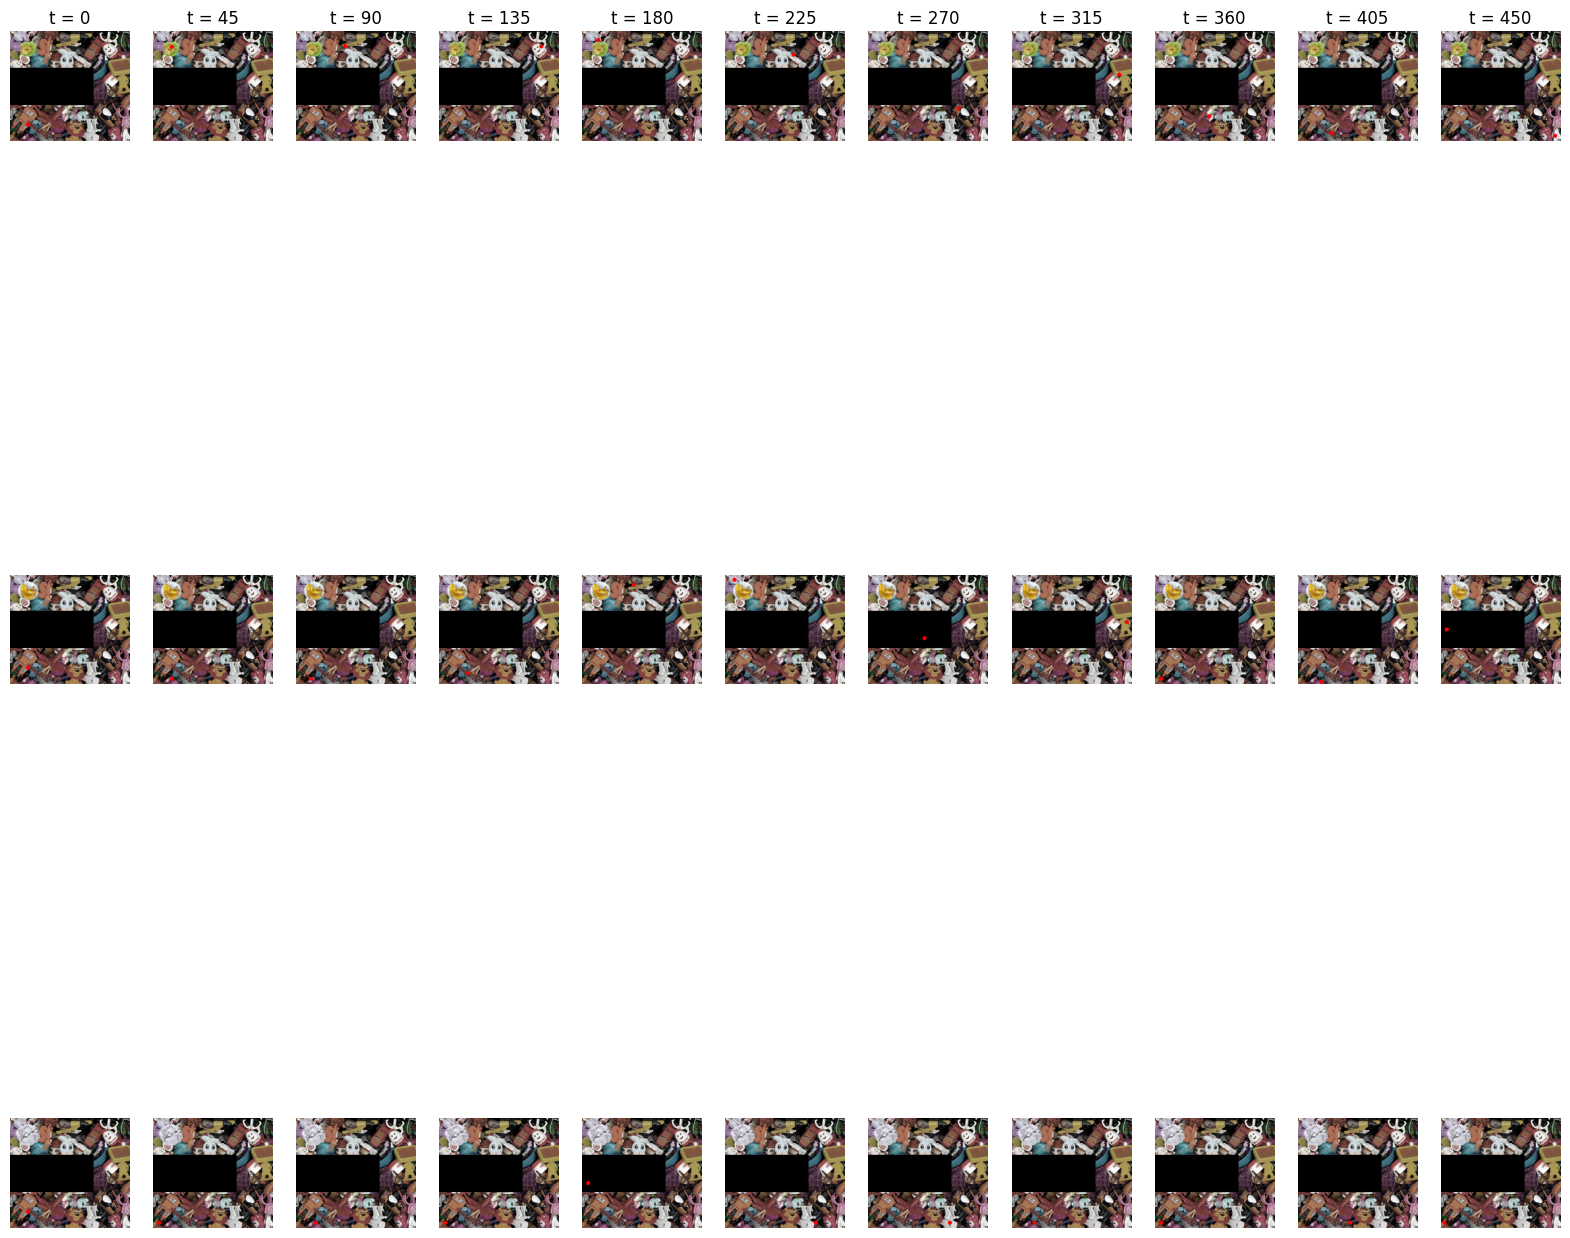

In [9]:
# eval_samples=1000
bg = gen_obstacles(bg, obstacle_pos)
new_goals = torch.tensor([[[-0.7, -0.7]]]*3, device=device, dtype=torch.float32)
obs_T = overlay_goal(bg, img_size, wastes, new_goals) # (goal_num, 3, H, W)

c = 10
fig,axs = plt.subplots(3, c + 1, figsize=(20,20))
T = diffusion.noise_steps
step_size = int(T / c)
dot_size = 4

model.eval()
ims = []
with torch.no_grad():
    x_T = torch.tensor([[[0.7, -0.7]]]*3, device=device, dtype=torch.float32)
    # x_T = gen_goals(agent_bounds, n=(goal_num, 1))
    x = x_T
    
    for i in tqdm(reversed(range(1, noise_steps)), position=0):
        bkg = bg.copy()
        im = overlay_goal_agent(bkg, wastes, new_goals.cpu(), x.cpu(), dot_size)
        ims.append(im)

        if (T-1-i) % step_size == 0:
            k = (T-1-i) // step_size
            backg = bg.copy()
            img_sample = overlay_goal_agent(backg, wastes, new_goals.cpu(), x.cpu(), dot_size)
            for s in range(len(img_sample)):
                axs[s,k].imshow(img_sample[s])
                axs[0,k].set_title(f't = {T-1-i}')
                axs[s,k].axis('off')

        t = (torch.ones(1) * i).long().to(device)
        while True:
            score = model(obs_T, t, x)
#             print(score)
            x = x + (score) + (torch.randn_like(x) * 0.1)
            
            mask = (x.abs() > 1)
            x[mask] = torch.clamp(x[mask], min=-.9, max=.9)
            if (x.abs() <=1).all():
                break

    backg = bg.copy()
    img_sample = overlay_goal_agent(backg, wastes, new_goals.cpu(),x.cpu(), dot_size)
    for s in range(len(img_sample)):
        axs[s,-1].imshow(img_sample[s])
        axs[0,-1].set_title(f't = {T}')
        axs[s,-1].axis('off')

    bkg = bg.copy()
    im = overlay_goal_agent(bkg, wastes, new_goals.cpu(), x.cpu(), dot_size)       
    ims.append(im)
#     x_trace.append(x)

In [10]:
np.save('./results/heat/single_goal/img_list.npy', ims)

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:518: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.asanyarray(arr)
/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
c = 10
fig,axs = plt.subplots(1, c + 1, figsize=(20,20))
axs = axs.flatten()
T = diffusion.noise_steps
step_size = int(T / c)
dot_size = 2

goals = gen_goals(goal_bounds, goal_num)

objs = wastes.copy()
gs = goals.clone()

obs_T = overlay_images(bg, img_size, objs, gs)

imgs = []

model.eval()
with torch.no_grad():
    # x_T = torch.tensor([[0.5, 0.5]], device=device, dtype=torch.float32)
    x_T = gen_goals(agent_bounds, n=(1, eval_samples)).unsqueeze(0)
    x = x_T
    
    imgs=[]
    for i in tqdm(reversed(range(1, noise_steps)), position=0):
        if (T-1-i) % step_size == 0:
            k = (T-1-i) // step_size
            img_sample = overlay_goals_agent(bg, objs, gs.cpu(), x.cpu(), dot_size)
            axs[k].imshow(img_sample)
            axs[k].set_title(f't = {T-1-i}')
            axs[k].axis('off')
            imgs.append(img_sample)

        t = (torch.ones(1) * i).long().to(device)
        while True:
            predicted_noise = model(obs_T, x, t)
            alpha = diffusion.alpha[t]
            alpha_hat = diffusion.alpha_hat[t]
            beta = diffusion.beta[t]
            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) \
                        * predicted_noise) + torch.sqrt(beta) * noise
            # if (abs(x[0][0]) <= 1.) & (abs(x[0][1]) <= 1.):
            #     break
            mask = (x.abs() > 1)
            x[mask] = torch.clamp(x[mask], min=-.9, max=.9)
            if (x.abs() <=1).all():
                break

#         exclude_idx = -1
#         for i in range(len(gs)):
#             if get_distance(x[0], gs[i]) < 0.1 and len(gs) > 1:
#                 exclude_idx = i
#                 break
#         if exclude_idx > -1:
#             objs = objs[:i] + objs[i+1:]
#             gs = torch.cat([gs[:i], gs[i+1:]], dim=0)
#             obs_T = overlay_images(bg, img_size, objs, gs)

    img_sample = overlay_goals_agent(bg, objs, gs.cpu(),x.cpu(), dot_size)
    axs[-1].imshow(img_sample)
    axs[-1].set_title(f't = {T}')
    axs[-1].axis('off')
    imgs.append(img_sample)

In [ ]:
np.save('./results/new_goals_video/img_list.npy', imgs)